# QAOA Sample Task

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import time
import operator
from scipy.optimize import minimize

# Better image quality.
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

# Import Qiskit libraries.
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import optimization
from qiskit.visualization import plot_histogram

# Import algorithms from Qiskit Aqua.
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators.primitive_ops import PauliOp
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.operators.expectations import PauliExpectation
from qiskit.aqua.operators.state_fns import StateFn,CircuitStateFn
from qiskit.aqua.operators.primitive_ops import CircuitOp
from qiskit.aqua.operators.converters import CircuitSampler
from qiskit.aqua.operators import X, Y, Z, I,OperatorBase

# Import misc qiskit libraries.
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import pauli
from qiskit.quantum_info import Operator

from qiskit.extensions import unitary
from qiskit.extensions import HamiltonianGate

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

## Helper Methods

In [7]:
def generate_J(input_set):
    """
    Converts a number set to J (interaction matrix).
    
    @input_set : set of numbers to be partitioned (1D array).
    
    returns:
        J matrix.
    """
    n = input_set.size
    J = np.zeros((n,n))
    
    for i in range(0,n):
        for j in range(0,n):
            J[i,j] = input_set[i]*input_set[j]

    #normalize                
    J = J/np.sum(np.sum(J)) 
    return J

def Ising_Hamiltonian(J):
    """ 
    Defines the Ising (target) Hamiltonian.
        @J : Coupling coefficient matrix (assumes input is an n by n matrix).
    returns:
        Hamiltonian PauliOp object.
    """
    no_of_qbits = J.shape[0]
    
    # Initialize H_ising as identity operators.
    I_n = PauliOp(pauli.Pauli(label='I'*no_of_qbits)) 
    H_ising = I_n
  
    for i in range(0, no_of_qbits):
        for j in range(i, no_of_qbits):
            if i!=j:
                # Construct ZiZj terms in H.
                Z_i     = pauli.Pauli.pauli_single(no_of_qbits,i,"Z")
                Z_j     = pauli.Pauli.pauli_single(no_of_qbits,j,"Z")
                ZiZj    = Z_i*Z_j
                
                # Convert them to PauliOp objects.
                ZiZj    = PauliOp(ZiZj)
                
                # Append to H_ising.
                H_ising = H_ising + J[i,j]*ZiZj 
    
    # Remove the initial Identity string.
    H_ising = H_ising - I_n 
    return H_ising

def H_d(no_of_qbits):
    """
    Generates the so-called drive (initial) Hamiltonian.
    
    @no_of_qubits : Number of qubits in the system.
    
    returns:
        Driving Hamiltonian.
    """    
    # Initialize H_ising as identity operators.
    I_n = PauliOp(pauli.Pauli(label='I'*no_of_qbits))
    H_d = I_n
    
    for i in range(0,no_of_qbits):
        X_i = pauli.Pauli.pauli_single(no_of_qbits,i,"X")
        H_d = H_d + PauliOp(X_i)

    # Remove the initial Identity string.
    H_d = H_d - I_n
    return H_d 
            
def U_t(H,t):
    """
    Define the unitary evolution operator.
    
    @H : Input Hamiltonian PauliOp object. 
    @t : Float time for which the evolution takes place.
    
    returns:
        a unitary evolution operator.
    """
    U_t = HamiltonianGate(data=H,time=t).to_matrix()
    
    return U_t


## Algorithm Specific Modules

In [84]:

def U_op(circuit,beta,gamma,H_main,H_drive,qbit_arr):
        """
        Generate the unitary evolution of U_beta and U_gamma
        given the values of beta and gamma.
        
        @circuit : QuantumCircuit instance object.
        @beta    : Angle (time) for unitary evolution of U(P,beta).
        @gamma   : Angle (time) for unitary evolution of U(C,gamma).
        @H_main  : The target Hamiltonian.
        @H_drive : The initial Hamiltonian.
        @qbit_arr: Numpy array of qbits.    
        """
        U_t_main  = U_t(H_main ,gamma)
        U_t_drive = U_t(H_drive,beta)
        circuit.unitary(U_t_main,qbit_arr)
        circuit.unitary(U_t_drive,qbit_arr)
        circuit.barrier()
        return circuit

def exp_value_F(psi,F_op,backend,shots=1024):
    """
    Calcultes the expectation value <psi|F_op|psi>.
    
    @psi     : The wavefunction quantum circuit.
    @F_op    : The operator quantum circuit.
    @backend : Qiskit backend object.
    @shots   : Number of iterations.
    
    returns:
        Expectation value of the operator.
    """
    q_instance = QuantumInstance(backend, shots=shots)
    
    # Define the state to sample. F_op composed of psi vector.
    measurable_expression = StateFn(F_op, is_measurement=True).compose(psi)

    # Convert to expectation value.
    expectation = PauliExpectation().convert(measurable_expression)  

    # Get state sampler.
    sampler = CircuitSampler(q_instance).convert(expectation) 
    return sampler.eval().real


def psi_ket_beta_gamma(beta_gamma_arr,inp_set,p,H_main,H_drive,J,no_of_qbits):
    """
    Generate |psi(gamma,beta)> = U(beta,gamma)|+++..+>.
    
    @beta_gamma_arr : List of beta and gamma arrays.
    @inp_set        : Set of numbers to be partitioned (1D array).
    @p              : Depth parameter.
    @H_main         : Target Hamiltonian.
    @H_drive        : Initial Hamiltonian.
    @J              : Coupling coefficient matrix (assumes input is an n by n matrix).
    @no_of_qubits   : Number of qubits in the system.
    
    returns:
        Quantum circuit after the unitary evolution.
    """
    # Unpack beta,gamma.
    beta = beta_gamma_arr[:p]
    gamma = beta_gamma_arr[p:]

    # Initial state preparation  |++++...++>.
    psi_qc = QuantumCircuit(no_of_qbits)
    for i in range(0,no_of_qbits):
        psi_qc.h(i)                   
    
    # Preparing trial state |s> using U(beta,gamma).
    qbit_arr = list(np.arange(0,no_of_qbits,1))
    for i in range(0,p):
        psi_qc = U_op(psi_qc, beta[i], gamma[i], H_main, H_drive, qbit_arr)

    return psi_qc

def QAOA_Obj(beta_gamma_arr,inp_set,p,H_main,H_drive,J,no_of_qbits):
    """
    Calculates the objective function to be minimised which in this case is the 
    expectation value <psi(beta,gamma) | F | psi(beta,gamma)>.
    
    @beta_gamma_arr : List of beta and gamma arrays.
    @inp_set        : Set of numbers to be partitioned (1D array).
    @p              : Depth parameter.
    @H_main         : Target Hamiltonian.
    @H_drive        : Initial Hamiltonian.
    @J              : Coupling coefficient matrix (assumes input is an n by n matrix).
    @no_of_qubits   : Number of qubits in the system.
    
    returns:
        Expectation value of H_main.
    """
    # Get |psi(gamma,beta)> 
    psi_qc = psi_ket_beta_gamma(beta_gamma_arr,inp_set,p,H_main,H_drive,J,no_of_qbits)
    
    # convert to state function
    psi_ket = CircuitStateFn(psi_qc)
        
    # Calculate expectation value of C(z) (Hmain in this case)
    backend           = Aer.get_backend("qasm_simulator") #declare backend
    exp_value = exp_value_F(psi_ket,H_main,backend)    
    
    return exp_value

def counts_partition_set(input_set,counts):
    """
    Processes the counts distribution.
    
    @input_set : Set of numbers to be partitioned (1D array).
    @counts    : The distribution of counts.
    
    returns:
        The partitioned sets.
    """
    counts_max_state = max(counts.items(), key=operator.itemgetter(1))[0] #returns the state with max counts
    set_1 = []
    set_2 = []
    
    
    for index,state in enumerate(counts_max_state):
        if state == '0': set_1.append(input_set[index])
        elif state == '1': set_2.append(input_set[index])
            
    return set_1,set_2

In [50]:
## Algorithm
def QAOA_v1(inp_set,p):
    """ 
    QAOA algorithm: partitions the input set into
    two subsets S1 and S2 such that the sum of the numbers 
    in S1 equals the sum of the numbers in S2.
    
    Note: Beta,gamma have to be arrays with size =p
    
    @inp_set : Initial number set.
    @p       : Depth parameter.
    
    returns:
        The counts distribution and two partitioned sets S1 and S2 as def above.
    """
    
    no_of_qbits = np.array(inp_set).size
    J           = generate_J(inp_set)
    H_main      = Ising_Hamiltonian(J)
    H_drive     = H_d(no_of_qbits) 
    
    # Sample beta and gamma vals.
    beta_vals = np.random.choice(np.arange(0,np.pi,np.pi/10), p)
    gamma_vals = np.random.choice(np.arange(0,np.pi,np.pi/10), p)
    beta_gamma_arr = np.array([beta_vals,gamma_vals]) 
    
    # Minimise the QAOA object function.
    res = minimize(QAOA_Obj, x0=beta_gamma_arr, args=(inp_set,p,H_main,H_drive,J,no_of_qbits),method='powell')
    
    """
    adam optimiser
    obj_f= lambda beta,gamma: QAOA_Obj([beta,gamma],inp_set,p,H_main,H_drive,J,no_of_qbits)
    adam = ADAM()
    res = adam.optimize(num_vars=2,objective_function=obj_f)
    """
    qc_result = psi_ket_beta_gamma(res['x'],inp_set,p,H_main,H_drive,J,no_of_qbits)
    qc_result.barrier()
    qc_result.measure_all()
    backend = Aer.get_backend("qasm_simulator")
    # Run the simulation and get the counts.
    counts = execute(qc_result, backend, shots = 1000).result().get_counts()
    set_1,set_2 = counts_partition_set(inp_set,counts)
    
    return counts, set_1, set_2   

### Running on a test set

In [88]:
input_set = np.array([11, 7, 8, 4])

### p=1

In [89]:
p = 1
counts,set_1,set_2 = QAOA_v1(input_set,p)

The two partitioned sets:
 [11, 4] 
 [7, 8]


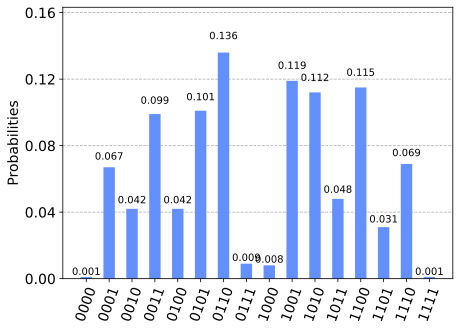

In [90]:
print("The two partitioned sets:\n", set_1,"\n", set_2)
plot_histogram(counts)

#### p=2

In [93]:
p = 2
counts,set_1,set_2 = QAOA_v1(input_set,p)

The two partitioned sets:
 [7, 8] 
 [11, 4]


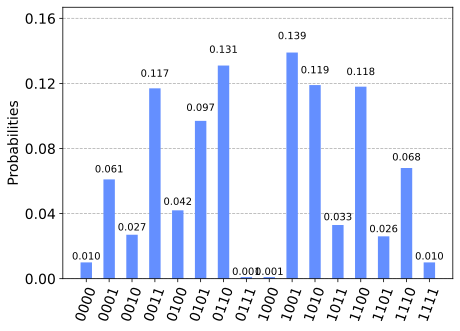

In [94]:
print("The two partitioned sets:\n", set_1,"\n", set_2)
plot_histogram(counts)

#### p=3

In [91]:
p = 3
counts,set_1,set_2 = QAOA_v1(input_set,p)

The two partitioned sets:
 [7, 8] 
 [11, 4]


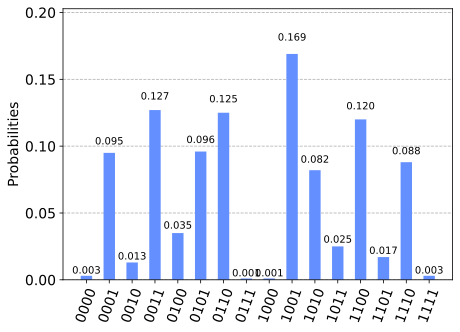

In [92]:
print("The two partitioned sets:\n", set_1,"\n", set_2)
plot_histogram(counts)